In [1]:

# Default locations if parameter not passed
benchmark_data_path = "sim-compare.pkl"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'sim_rr', 'full_output', 'sim_device_number', 'sim_task_number',
       'sim_deviation', 'time'],
      dtype='object')

name  sim_rr  \
0  time-measure-task       2   
1  time-measure-task       2   
2  time-measure-task       2   
3  time-measure-task       2   
4  time-measure-task       2   

                                         full_output  sim_device_number  \
0  Time Simulation (microseconds) : 958 \nDistanc...                100   
1  Time Simulation (microseconds) : 1013 \nDistan...                100   
2  Time Simulation (microseconds) : 1002 \nDistan...                100   
3  Time Simulation (microseconds) : 1013 \nDistan...                100   
4  Time Simulation (microseconds) : 1012 \nDistan...                100   

   sim_task_number  sim_deviation      time  
0              100            NaN  0.190065  
1              100            NaN  0.183416  
2              100            NaN  0.176402  
3              100            NaN  0.175200  
4              100            NaN  0.181641

name  sim_rr                                        full_output  \
1595  dist-measure      16  Time Simulation (microseconds) : 1261 \nDistan...   
1596  dist-measure      16  Time Simulation (microseconds) : 1254 \nDistan...   
1597  dist-measure      16  Time Simulation (microseconds) : 1223 \nDistan...   
1598  dist-measure      16  Time Simulation (microseconds) : 1255 \nDistan...   
1599  dist-measure      16  Time Simulation (microseconds) : 1233 \nDistan...   

      sim_device_number  sim_task_number  sim_deviation      time  
1595                 20              500            5.0  0.190488  
1596                 20              500            5.0  0.195164  
1597                 20              500            5.0  0.196432  
1598                 20              500            5.0  0.210503  
1599                 20              500            5.0  0.190052

In [3]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [4]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [5]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()




Benchmark: time-measure-task - Runs: 10
--- Row 0 ---
name: time-measure-task
sim_rr: 2
full_output: Time Simulation (microseconds) : 958 
Distance : 6.45583e-16


sim_device_number: 100
sim_task_number: 100
sim_deviation: nan
time: 0.19006463582627475

--- Row 1 ---
name: time-measure-task
sim_rr: 2
full_output: Time Simulation (microseconds) : 1013 
Distance : 7.45728e-16


sim_device_number: 100
sim_task_number: 100
sim_deviation: nan
time: 0.1834164911415428

--- Row 2 ---
name: time-measure-task
sim_rr: 2
full_output: Time Simulation (microseconds) : 1002 
Distance : 3.76407e-16


sim_device_number: 100
sim_task_number: 100
sim_deviation: nan
time: 0.17640187498182058

--- Row 3 ---
name: time-measure-task
sim_rr: 2
full_output: Time Simulation (microseconds) : 1013 
Distance : 1.23132e-15


sim_device_number: 100
sim_task_number: 100
sim_deviation: nan
time: 0.1752001540735364

--- Row 4 ---
name: time-measure-task
sim_rr: 2
full_output: Time Simulation (microseconds) : 1012 
Dis

# Experiment 1

time-measure-task

rr: fixed at 2
sim_device_number: fixed at 100
y: Execution time (last line) 
x: sim_task_number


In [6]:
import re
import numpy as np

def extract_sim_time(text):
    """
    From a blob like:
    
      "... Time Simulation (microseconds) : 874  \n Distance : 2.52673e-16 ..."
    
    extract 874, interpret it as microseconds, convert to seconds → 0.000874
    Returns np.nan if no match is found.
    """
    # look for "Time Simulation (microseconds) : <number>"
    matches = re.findall(
        r"Time Simulation\s*\(microseconds\)\s*:\s*([0-9]+(?:\.[0-9]*)?)",
        str(text),
    )
    if not matches:
        return np.nan
    # take the last one (in case there's more than one), convert to float, then to seconds
    micro = float(matches[-1])
    return micro * 1e-6
   

In [7]:
df_time_task = df[df["name"] == "time-measure-task"].copy()
df_time_task["sim_time"] = df_time_task["full_output"].apply(extract_sim_time)
df_time_task = df_time_task[["sim_task_number", "sim_time", "sim_rr"]]

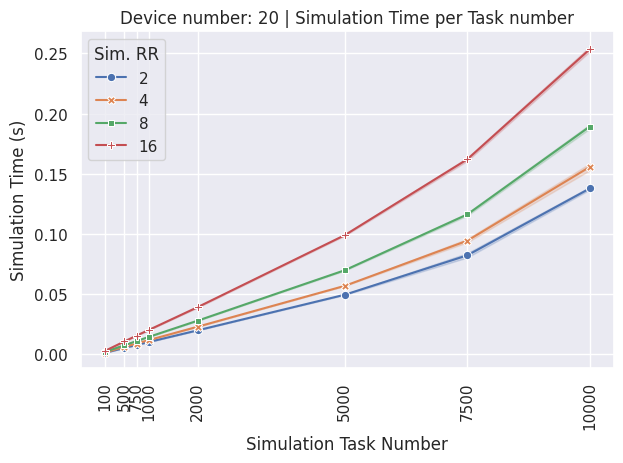

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_time_task and contains 'sim_task_number' and 'sim_time'
plt.figure()
sns.lineplot(
    data=df_time_task,
    x="sim_task_number",
    y="sim_time",
    hue="sim_rr",  # assuming sim_rr is a categorical variable for different runs
    style="sim_rr",  # use different line styles for different runs
    markers=True,
    palette="deep",
    dashes=False,  # use solid lines
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Simulation Task Number")
plt.ylabel("Simulation Time (s)")
plt.title("Device number: 20 | Simulation Time per Task number")
plt.xticks(sorted(df_time_task["sim_task_number"].unique()))
plt.legend(title="Sim. RR")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 2: time-measure-device

sim_task_number: fixed at 1000
y_axis: Execution time
x_axis: sim_device_number

In [9]:
df_device_task = df[df["name"] == "time-measure-device"].copy()
df_device_task["sim_time"] = df_device_task["full_output"].apply(extract_sim_time)
df_device_task = df_device_task[["sim_device_number", "sim_time", "sim_rr"]]

print(df_device_task.head())


     sim_device_number  sim_time  sim_rr
320                 20  0.001066       2
321                 20  0.001058       2
322                 20  0.001058       2
323                 20  0.001063       2
324                 20  0.001118       2


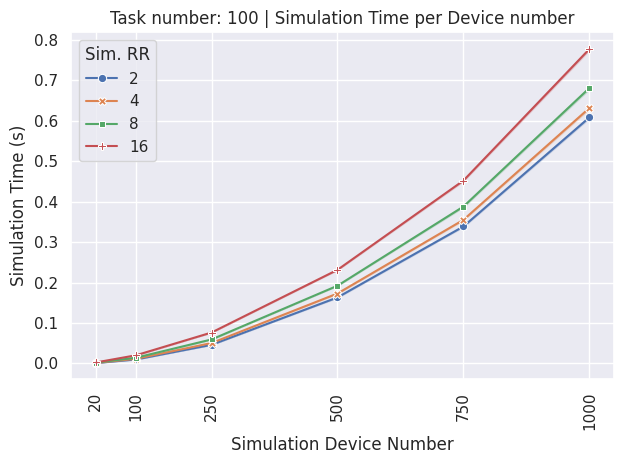

In [10]:
plt.figure()
sns.lineplot(
    data=df_device_task,
    x="sim_device_number",
    y="sim_time",
    hue="sim_rr",  # assuming sim_rr is a categorical variable for different runs
    dashes=False,
    markers=True,
    style="sim_rr",
    palette="deep",
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Simulation Device Number")
plt.ylabel("Simulation Time (s)")
plt.title("Task number: 100 | Simulation Time per Device number")
plt.legend(title="Sim. RR")
plt.xticks(sorted(df_device_task["sim_device_number"].unique()))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 3

x-axsis: sim_devation
y-axis: distance (float)

one line per sim_rr

In [11]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Extraction
def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

# 2) Build df_dist
df_dist = df[df["name"] == "dist-measure"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["sim_deviation", "sim_rr", "distance"]]

print(df_dist.head())


     sim_deviation  sim_rr      distance
560            0.0       2  9.440920e-16
561            0.0       2  1.058910e-15
562            0.0       2  6.735620e-16
563            0.0       2  1.789620e-15
564            0.0       2  5.033660e-16


/tmp/ipykernel_2052114/1495727988.py:3: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(


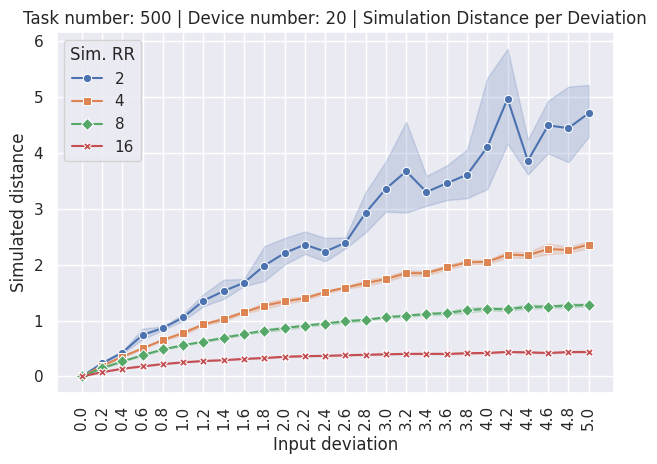

In [12]:
plt.figure()
markers = ["o", "s", "D", "X", "v", "^"]
sns.lineplot(
    data=df_dist,
    x="sim_deviation",
    y="distance",
    hue="sim_rr",
    style="sim_rr",
    markers=markers,
    dashes=False,
    palette="deep",
    errorbar="ci"
)
plt.xlabel("Input deviation")
plt.ylabel("Simulated distance")
plt.title("Task number: 500 | Device number: 20 | Simulation Distance per Deviation")
plt.legend(title="Sim. RR", loc="upper left")
plt.xticks(sorted(df_dist["sim_deviation"].unique()), rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()